In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

/Users/zhaluza/opt/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


Conert MNIST images to tensors

In [4]:
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(
    root="../Data", train=True, download=True, transform=transform
)


In [6]:
test_data = datasets.MNIST(
    root="../Data", train=False, download=True, transform=transform
)


Let's check our training and test data:

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [9]:
type(train_data)

torchvision.datasets.mnist.MNIST

The training data is stored as an array of tuples:

`[ (tensor, label), ... ]`

In [10]:
image, label = train_data[0]

In [11]:
image.shape

torch.Size([1, 28, 28])

In [12]:
label

5

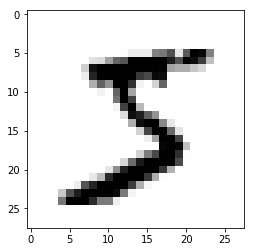

In [13]:
# Visualize this
plt.imshow(image.reshape((28, 28)), cmap="gist_yarg")
# override matplotlib default color mapping (viridis)


In [14]:
# Load our training data in batches
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)


In [15]:
from torchvision.utils import make_grid

np.set_printoptions(formatter=dict(int=lambda x: f"{x:4}"))  # Formatting


In [16]:
# FIRST BATCH
for images,labels in train_loader:
    # 60,000 / 100: 60 times
    # We just want the first batch though
    # Break the loop to give us the first batch
    break

In [17]:
images.shape

torch.Size([100, 1, 28, 28])

In [18]:
labels.shape

torch.Size([100])

Let's view our batch of images.

Lables:  [   0    5    7    8    6    7    9    7    1    3    8    4]


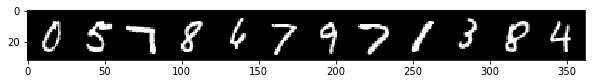

In [19]:
# Print the first 12 labels
print("Lables: ", labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # default nrow is 8
plt.figure(figsize=(10, 4))
# Transpose images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));


In [20]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layers=[120, 84]):
        super().__init__()

        self.fully_connected_1 = nn.Linear(input_size, layers[0])
        self.fully_connected_2 = nn.Linear(layers[0], layers[1])
        self.fully_connected_3 = nn.Linear(layers[1], output_size)

    def forward(self, X):
        X = F.relu(self.fully_connected_1(X))
        X = F.relu(self.fully_connected_2(X))
        X = self.fully_connected_3(X)

        return F.log_softmax(X, dim=1) # Multi-class classification


In [21]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fully_connected_1): Linear(in_features=784, out_features=120, bias=True)
  (fully_connected_2): Linear(in_features=120, out_features=84, bias=True)
  (fully_connected_3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
# ANN ---> CNN
# We want to solve this with CNN later since CNN contains fewer paramaters
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


We have 105,214 total parameters with our ANN model. A CNN will be much more efficient.

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
# We need to flatten our images to a [100, 784] shape
images.shape

torch.Size([100, 1, 28, 28])

In [25]:
images.view(100, -1).shape

torch.Size([100, 784])

It's time to train our model.

In [26]:
import time

start_time = time.time()

# TRAINING
epochs = 10

# Optional trackers - good for visualizing our results
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    trn_correct = 0
    tst_correct = 0

    for batch, (X_train, y_train) in enumerate(train_loader):
        batch += 1

        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]  # The digits that the output predicts
        batch_correct = (predicted == y_train).sum()
        trn_correct += batch_correct

        # Update our parameters with backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 200 == 0:
            acc = trn_correct.item() * 100 / (100 * batch)
            print(
                f"Epoch {epoch}, batch {batch}; loss: {loss.item()}, accuracy: {acc}"
            )

    # Update training loss/correct counts
    train_losses.append(loss)
    train_correct.append(trn_correct)

    with torch.no_grad(): # Don't update weights & biases w/ test data
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            predicted = torch.max(y_val.data, 1)[1]
            tst_correct += (predicted == y_test).sum()

    # Update loss & test accuracy for epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_correct)

# CALCULATE TIME THAT HAS PASSED
total_time = time.time() - start_time
print(f"Duration: {total_time / 60} mins")


Epoch 0, batch 200; loss: 0.2805541157722473, accuracy: 83.04
Epoch 0, batch 400; loss: 0.2030348777770996, accuracy: 87.325
Epoch 0, batch 600; loss: 0.20227621495723724, accuracy: 89.32333333333334
Epoch 1, batch 200; loss: 0.1445707231760025, accuracy: 94.56
Epoch 1, batch 400; loss: 0.10489681363105774, accuracy: 95.11
Epoch 1, batch 600; loss: 0.12034713476896286, accuracy: 95.34666666666666
Epoch 2, batch 200; loss: 0.11627214401960373, accuracy: 96.53
Epoch 2, batch 400; loss: 0.0890628844499588, accuracy: 96.615
Epoch 2, batch 600; loss: 0.10235453397035599, accuracy: 96.74
Epoch 3, batch 200; loss: 0.05358918756246567, accuracy: 97.475
Epoch 3, batch 400; loss: 0.054050594568252563, accuracy: 97.475
Epoch 3, batch 600; loss: 0.05676334723830223, accuracy: 97.51333333333334
Epoch 4, batch 200; loss: 0.13540565967559814, accuracy: 97.945
Epoch 4, batch 400; loss: 0.09042362868785858, accuracy: 98.01
Epoch 4, batch 600; loss: 0.12622961401939392, accuracy: 98.04666666666667
Epoch

Time to plot out our results.

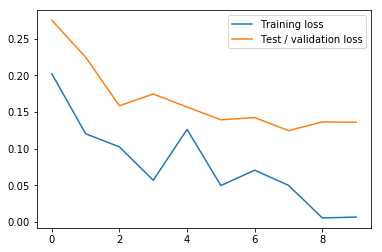

In [27]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label = "Test / validation loss")
plt.legend();

In [28]:
train_acc = [t / 600 for t in train_correct]

In [29]:
test_acc = [t / 100 for t in test_correct]

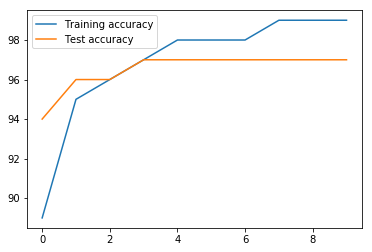

In [30]:
plt.plot(train_acc, label="Training accuracy")
plt.plot(test_acc, label="Test accuracy")
plt.legend();

In [31]:
# Working with new unseen data
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)


In [32]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()


In [38]:
print(f"Total accuracy on test set: {100 * correct.item() / len(test_data)}%")

Total accuracy on test set: 97.55%


In [39]:
confusion_matrix(predicted.view(-1), y_test.view(-1))


array([[ 971,    0,    1,    0,    1,    3,    4,    1,    3,    3],
       [   0, 1119,    3,    0,    0,    0,    4,    3,    0,    2],
       [   1,    5, 1001,    3,    1,    0,    2,    6,    2,    0],
       [   3,    2,   11,  998,    1,   20,    1,    3,    7,   14],
       [   0,    0,    3,    0,  966,    2,   10,    0,    3,   14],
       [   0,    0,    0,    0,    0,  854,    2,    0,    2,    4],
       [   1,    2,    2,    0,    2,    7,  933,    0,    1,    0],
       [   0,    1,    6,    4,    4,    0,    0, 1009,    4,   12],
       [   2,    6,    5,    4,    2,    6,    2,    4,  950,    6],
       [   2,    0,    0,    1,    5,    0,    0,    2,    2,  954]])